Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [13]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [14]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv ("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [15]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [16]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [17]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [18]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique())

['No Data']


In [19]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique())

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [20]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!='Suppressed'] 
diabetes = diabetes[diabetes['Obesity_Number']!='No Data'] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int)

# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!='Suppressed'] 
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!='No Data'] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int)

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [21]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [22]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes[rc_cols].describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,0.224208
Obesity_Number,3112.0,0.251666,0.088946,0.476788
Physical_Inactivity_Number,3112.0,0.200861,0.064949,0.392285
race_total population_one race,3112.0,0.976059,0.713126,1.000000
race_total population_two or more races,3112.0,0.023941,0.000000,0.286874
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000
race_total population_one race_black or african american,3112.0,0.090215,0.000000,0.874123
race_total population_one race_american indian and alaska native,3112.0,0.019398,0.000000,0.924799
race_total population_one race_american indian and alaska native_cherokee tribal grouping,3112.0,0.001791,0.000000,0.409669


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [23]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population_65 years and over_1',
 'sex and age_total population',
 'hispanic or latino and race_total population',
 'race_total population_one race_1',
 'race_total population_two or more races_1',
 'sex and age_total population_18 years and over_1']

In [24]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames, axis=1) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [25]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

In [27]:
print (diabetes)

                 County    State CountyFIPS  Diabetes_Number  Obesity_Number  \
0        Autauga County  Alabama      01001         0.093804        0.244366   
1        Baldwin County  Alabama      01003         0.080281        0.233255   
2        Barbour County  Alabama      01005         0.131875        0.310643   
3           Bibb County  Alabama      01007         0.105251        0.290052   
4         Blount County  Alabama      01009         0.108977        0.246804   
...                 ...      ...        ...              ...             ...   
3215  Sweetwater County  Wyoming      56037         0.058028        0.212208   
3216       Teton County  Wyoming      56039         0.019038        0.088946   
3217       Uinta County  Wyoming      56041         0.069872        0.238973   
3218    Washakie County  Wyoming      56043         0.078361        0.213802   
3219      Weston County  Wyoming      56045         0.084648        0.283803   

      Physical_Inactivity_Number  \
0  

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

In [28]:
print(diabetes.shape)

(3112, 90)


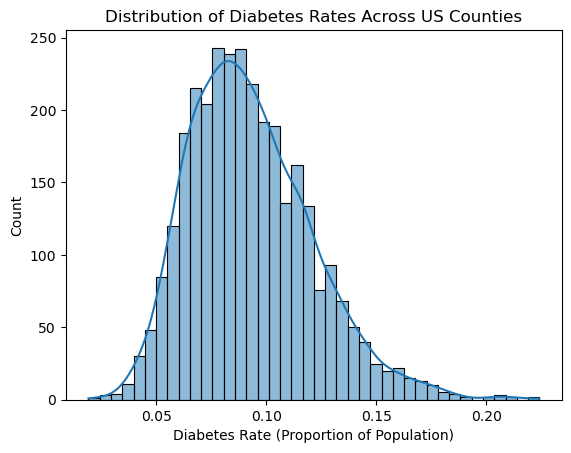

In [29]:
# EDA ONE: Histogram to visualize the distribution of diabetes rates
#
#-----------
sns.histplot(diabetes['Diabetes_Number'], kde=True, bins=40) 
plt.title('Distribution of Diabetes Rates Across US Counties') 
plt.xlabel('Diabetes Rate (Proportion of Population)') 
plt.show()

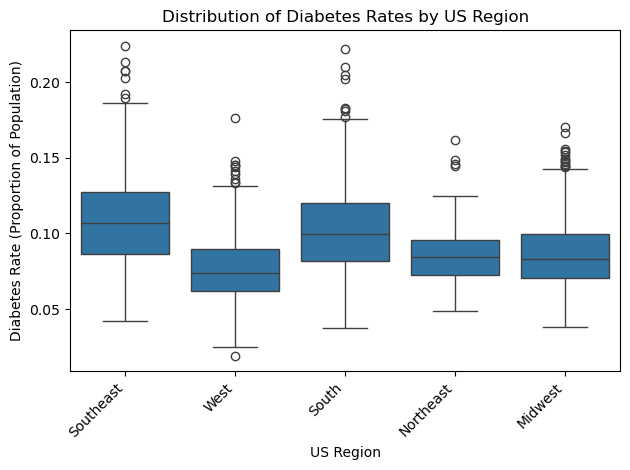

In [31]:
# EDA TWO: Boxplot to visualize the relationship between diabetes rates and the US regions
# EDA #2 and interpretations in this section 
#-----------
sns.boxplot(x='Region', y='Diabetes_Number', data=diabetes) # <-- 'diabetes' contains the 'Region' column?
plt.title('Distribution of Diabetes Rates by US Region')
plt.xlabel('US Region')
plt.ylabel('Diabetes Rate (Proportion of Population)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [32]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [33]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target
# and "race alone or in combination with one or more other races_total population"
#'Region' and the duplicate race columns were already dropped from diabetes_clean earlier.
x = diabetes_clean.drop(columns=['Diabetes_Number','race alone or in combination with one or more other races_total population','CountyFIPS'], axis=1)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [102]:
#
# Feature selection
# Dropped features identified as highly redundant or perfectly collinear
#Assuming these were the columns identified as duplicates earlier:
#-----------
# choosing to let ML filter out variables 

X shape after feature reduction: (3112, 87)


In [57]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)

# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(x,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [58]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(
    X_test,         # Use the 40% initial test features
    y_test,         # Use the 40% initial test target
    train_size=0.75,
    test_size=0.25)          # Split the 40% in half (0.5 * 0.4 = 0.2, or 20% final test set)



In [59]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()
print("Standardization complete for continuous features across all sets.")

Standardization complete for continuous features across all sets.


## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** ...

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  LASSO 

In [60]:
#
# Model 1 training
#-----------
# Import the necessary libraries
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1. Initialize and train the LASSO model
# As suggested, we start with a small alpha to avoid convergence issues.
lasso_model = Lasso(alpha=0.001, random_state=42)

# Train the model on the training data
lasso_model.fit(X_train, y_train)

# 2. Evaluate the model on the training data
# Make predictions on the training set to see how well the model fits it.
y_train_pred = lasso_model.predict(X_train)

# Calculate performance metrics
r2 = r2_score(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)

# 3. Report summary statistics
print("--- LASSO Model Training Set Performance ---")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}\n")

# 4. Inspect the coefficients
# This shows the power of LASSO's feature selection.
coefficients = lasso_model.coef_
num_features_used = np.sum(coefficients != 0)
total_features = len(coefficients)

print(f"--- Feature Selection ---")
print(f"Out of {total_features} features, LASSO selected {num_features_used} by setting the rest to zero.")


--- LASSO Model Training Set Performance ---
R-squared: 0.4745
Mean Absolute Error (MAE): 0.0147
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0196

--- Feature Selection ---
Out of 88 features, LASSO selected 18 by setting the rest to zero.


#### Model 2:  OLS

In [61]:
#
# Model 2 training
#-----------
# 1. Import the necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 2. Initialize and train the OLS model
# The LinearRegression() class in scikit-learn implements OLS.
ols_model = LinearRegression()

# Train the model on the training data
ols_model.fit(X_train, y_train)

# 3. Evaluate the model on the training data
# Make predictions on the training set to measure the fit.
y_train_pred_ols = ols_model.predict(X_train)

# Calculate performance metrics
r2_ols = r2_score(y_train, y_train_pred_ols)
mae_ols = mean_absolute_error(y_train, y_train_pred_ols)
mse_ols = mean_squared_error(y_train, y_train_pred_ols)
rmse_ols = np.sqrt(mse_ols)

# 4. Report summary statistics
print("--- OLS Model Training Set Performance ---")
print(f"R-squared: {r2_ols:.4f}")
print(f"Mean Absolute Error (MAE): {mae_ols:.4f}")
print(f"Mean Squared Error (MSE): {mse_ols:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ols:.4f}\n")

# 5. Inspect the coefficients
# In OLS, all features will have a non-zero coefficient.
ols_coefficients = ols_model.coef_
ols_intercept = ols_model.intercept_

print(f"--- Model Intercept ---")
print(f"Intercept: {ols_intercept:.4f}")
# You can optionally print all coefficients, but it will be a long list.
# print("\n--- Model Coefficients ---")
# for feature, coef in zip(X_train.columns, ols_coefficients):
#     print(f"{feature}: {coef:.4f}")


--- OLS Model Training Set Performance ---
R-squared: 0.5487
Mean Absolute Error (MAE): 0.0134
Mean Squared Error (MSE): 0.0003
Root Mean Squared Error (RMSE): 0.0182

--- Model Intercept ---
Intercept: 0.0883


#### Model 3:  KNN 

In [62]:
#
# Model 3 training
#-----------
# 1. Import the necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 2. Initialize and train the KNN model
# We'll start with k=5 neighbors, a common default. This is a hyperparameter you can tune later.
knn_model = KNeighborsRegressor(n_neighbors=5)

# Train the model on the training data
knn_model.fit(X_train, y_train)

# 3. Evaluate the model on the training data
# Make predictions on the training set to measure the fit.
y_train_pred_knn = knn_model.predict(X_train)

# Calculate performance metrics
r2_knn = r2_score(y_train, y_train_pred_knn)
mae_knn = mean_absolute_error(y_train, y_train_pred_knn)
mse_knn = mean_squared_error(y_train, y_train_pred_knn)
rmse_knn = np.sqrt(mse_knn)

# 4. Report summary statistics
print("--- KNN Model Training Set Performance (k=5) ---")
print(f"R-squared: {r2_knn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_knn:.4f}")
print(f"Mean Squared Error (MSE): {mse_knn:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_knn:.4f}\n")


--- KNN Model Training Set Performance (k=5) ---
R-squared: 0.5084
Mean Absolute Error (MAE): 0.0148
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0190



## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [63]:
ols_pred_validate = ols_model.predict(X_validate)

r2_ols = r2_score(y_validate, ols_pred_validate)
mae_ols = mean_absolute_error(y_validate, ols_pred_validate)
mse_ols = mean_squared_error(y_validate, ols_pred_validate)
rmse_ols = np.sqrt(mse_ols)
print(rmse_ols)
print(r2_ols)



0.0766944866669541
-6.019240827405987


In [64]:
#
# Predict on validation data
#-----------
# To avoid repeating code, let's create a helper function to evaluate a model
def evaluate_model(model, X_val, y_val, model_name):
    """Predicts and evaluates a model on a validation set."""
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate performance metrics
    r2 = r2_score(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    
    # Print results
    print(f"--- {model_name} Validation Performance ---")
    print(f"R-squared: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}\n")

# --- Evaluate all three models ---

# 1. LASSO Model
evaluate_model(lasso_model, X_validate, y_validate, "LASSO")

# 2. OLS Model
evaluate_model(ols_model, X_validate, y_validate, "OLS")

# 3. KNN Model
evaluate_model(knn_model, X_validate, y_validate, "KNN")


--- LASSO Validation Performance ---
R-squared: 0.4845
Mean Absolute Error (MAE): 0.0156
Root Mean Squared Error (RMSE): 0.0208

--- OLS Validation Performance ---
R-squared: -6.0192
Mean Absolute Error (MAE): 0.0499
Root Mean Squared Error (RMSE): 0.0767

--- KNN Validation Performance ---
R-squared: 0.2280
Mean Absolute Error (MAE): 0.0198
Root Mean Squared Error (RMSE): 0.0254



### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [110]:
#
# Predict using your best model
#-----------
import pandas as pd

# 1. Combine the training and validation sets
# This gives the model more data to learn from before the final test.
X_train_full = pd.concat([X_train, X_validate])
y_train_full = pd.concat([y_train, y_validate])

print(f"Combined training data shape: {X_train_full.shape}")

# 2. Retrain your best model on the combined data
# We re-initialize the model to ensure it's a fresh training run.
best_model = Lasso(alpha=0.001, random_state=42) # Assuming LASSO was the best
best_model.fit(X_train_full, y_train_full)

print("\nBest model (LASSO) retrained on full training + validation data.")

# 3. Evaluate the final model on the test set
# This is the final, unbiased performance of your chosen model.
evaluate_model(best_model, X_test, y_test, "FINAL LASSO MODEL ON TEST DATA")


Combined training data shape: (1245, 87)

Best model (LASSO) retrained on full training + validation data.
--- FINAL LASSO MODEL ON TEST DATA Validation Performance ---
R-squared: -0.0028
Mean Absolute Error (MAE): 0.0000
Root Mean Squared Error (RMSE): 0.0000



In [65]:
evaluate_model(lasso_model, X_test, y_test, "LASSO")


--- LASSO Validation Performance ---
R-squared: 0.4760
Mean Absolute Error (MAE): 0.0150
Root Mean Squared Error (RMSE): 0.0200



### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [67]:
#
# Run cross-validation
#-----------
from sklearn.model_selection import cross_val_score

# 1. Use the combined training + validation dataset (X_train_full, y_train_full)
# 2. Use the same model definition as your best model
final_model_for_cv = Lasso(alpha=0.001, random_state=42)

# 3. Perform 5-fold cross-validation
# We'll calculate the negative root mean squared error. Scikit-learn uses negative
# error metrics because its convention is to maximize a score.
cv_scores = cross_val_score(final_model_for_cv, 
                            X_train, 
                            y_train, 
                            cv=5, 
                            scoring='neg_root_mean_squared_error')

# 4. Convert scores back to positive RMSE and report results
cv_rmse_scores = -cv_scores
mean_cv_rmse = cv_rmse_scores.mean()
std_cv_rmse = cv_rmse_scores.std()

print("--- 5-Fold Cross-Validation Results (RMSE) ---")
print(f"Scores for each fold: {np.round(cv_rmse_scores, 4)}")
print(f"Mean RMSE: {mean_cv_rmse:.4f}")
print(f"Standard Deviation of RMSE: {std_cv_rmse:.4f}")


--- 5-Fold Cross-Validation Results (RMSE) ---
Scores for each fold: [0.0202 0.0185 0.0217 0.0217 0.021 ]
Mean RMSE: 0.0206
Standard Deviation of RMSE: 0.0012


## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

**YOUR ANSWER HERE**...

2. Define overfitting, and why it matters for machine learning. How can we address it?

**YOUR ANSWER HERE**...

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**YOUR ANSWER HERE**...